# COGS 108 - EDA Checkpoint

# Names

- Jackson Conte
- Andrew Nguyen
- Anish Rajeshkumar
- Bara Zakeria

<a id='research_question'></a>
# Research Question

Is there a correlation between the proportion of the type of shot (e.g. fieldgoal, 3-point, free throw) and playoff success (i.e. advancement into the playoffs) in the past 20 years for the National Basketball Association (NBA)?

# Setup

In [1]:
## YOUR CODE HERE

# upgrade pip
!{sys.executable} -m pip install --upgrade pip

#install external libraries
import sys
!{sys.executable} -m pip install nba_api # nba stats
!{sys.executable} -m pip install pandera # data validation 

# DS/Visualization libraries
import pandas as pd
import numpy as np
from pathlib import Path
import pandera as pa
from pandera import Check, Column, DataFrameSchema, DateTime, check
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import iplot
import plotly.figure_factory as ff
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# notebook configurations
pd.options.display.max_colwidth = 1000
%matplotlib inline

# NBA API libraries
## team info
from nba_api.stats.static import teams
## team stats
from nba_api.stats.endpoints import teamyearbyyearstats as teamyears

print("\n**ALL LIBRARIES IMPORTED SUCCESSFULLY**")

/bin/bash: {sys.executable}: command not found
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning:

pandas.Int6


**ALL LIBRARIES IMPORTED SUCCESSFULLY**


# Data Cleaning <a name="dc">

<!--*Fill in your dataset information here*-->

<!--*(Copy this information for each dataset)*-->
- Dataset Name: National Basketball Association (NBA) Statistics
- Link to the dataset:
    - [nba_api](https://github.com/swar/nba_api): ```General website (API)```
        - [teamyearbyyearstats](https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/teamyearbyyearstats.md): ```Dataset (Endpoint)```
            - Source: Swar. “NBA_API/Teamyearbyyearstats.md at Master · Swar/NBA_API.” GitHub, https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/teamyearbyyearstats.md. 
        - [teams.py](https://github.com/swar/nba_api/blob/master/src/nba_api/stats/static/players.py): ```Helper script```
            - Source: Swar. “Nba_api/Players.py at Master · Swar/NBA_API.” GitHub, https://github.com/swar/nba_api/blob/master/src/nba_api/stats/static/players.py. 
- Number of observations: ```1,597```

<!--*1-2 sentences describing each dataset.*-->

The ```teamyearbyyearstats``` endpoint has records by season for each NBA team from the 1949 season. To extract each team's data from the endpoint, their respective ID is called from ```teams.py``` and the endpoint outputs the respective ```DataFrame()```.

<!--*If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.*-->

**Features**

*Columns that are not listed below are solely for identification puproses (see ```data_dictionary``` above)*

- ```PO_WINS```: Playoff Wins- each team's performance in the playoffs
- ```PO_LOSSES```: Playoff Losses- each team's performance in the playoffs
- ```NBA_FINALS_APPEARANCE```: An indicator to determine whether the team apppeared in the finals or not
- ```FGM```: Field Goals Made- to determine the correlation between playoff success and type of shot
- ```FGA```: Field Goals Attempted- to determine the correlation between playoff success and type of shot
- ```FG_PCT```: Field Goals Percentage- to determine the correlation between playoff success and type of shot
- ```FG3M```: Field Goals Three's Made- to determine the correlation between playoff success and type of shot
- ```FG3A```: Field Goals Three's Attempted- to determine the correlation between playoff success and type of shot
- ```FG3_PCT```: Field Goals Three's Percentage- to determine the correlation between playoff success and type of shot
- ```FTM```: Free Throws Made- to determine the correlation between playoff success and type of shot
- ```FTA```: Free Throws Attempted- to determine the correlation between playoff success and type of shot
- ```FT_PCT```: Free Throws Percentage- to determine the correlation between playoff success and type of shot

Describe your data cleaning steps here.

1. **API**
    - Call the ```teamyearbyyearstats``` endpoint from the ```nba_api``` by each team's ID to output the dataframe (DF)
        - Combine all of the DFs into one DF
            - Save DF as ```nba_stats_raw.csv```
1. **Validation**
    - Subset the DF by columns of interest
    - Create test cases (e.g. data type constraints, range constraints, cross-field validation) for each column via the ```pandera``` library
        - [Pandera](https://pandera.readthedocs.io/en/stable/): a data validation library that aids in the data cleaning process to ensure the dataframe meets certain test cases in order conduct our analysis appropriately
        - Null test cases is accounted for automatically 
    - Validate the tests
        - Output the schema errors and DF errors into a seperate DF (e.g. ```schema_errors```, ```df_errors```)
1. **Cleaning**
    - Fix the respective test cases that failed
1. **Verification**
    - Validate the tests
        - Output the schema errors and DF errors into a seperate DF (e.g. ```schema_errors```, ```df_errors```)
1. **Export Data**
    - Save DF as ```nba_stats_cleaned.csv```
1. **Data Dictionary**
    - Create a data dictionary for the ```nba_stats_cleaned.csv``` dataset

In [2]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

import time
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION
team_ids = [t['id'] for t in teams.get_teams()]
df = pd.DataFrame()

# slow but effective
for i in team_ids:
    df = pd.concat([df, teamyears.TeamYearByYearStats(i).get_data_frames()[0]])
    time.sleep(0.4) # any lower and it'll time out
print(df)

       TEAM_ID   TEAM_CITY   TEAM_NAME     YEAR  GP  WINS  LOSSES  WIN_PCT  \
0   1610612737  Tri-Cities  Blackhawks  1949-50  64    29      35    0.453   
1   1610612737  Tri-Cities  Blackhawks  1950-51  68    25      43    0.368   
2   1610612737   Milwaukee       Hawks  1951-52  66    17      49    0.258   
3   1610612737   Milwaukee       Hawks  1952-53  71    27      44    0.380   
4   1610612737   Milwaukee       Hawks  1953-54  72    21      51    0.292   
..         ...         ...         ...      ...  ..   ...     ...      ...   
28  1610612766   Charlotte     Hornets  2018-19  82    39      43    0.476   
29  1610612766   Charlotte     Hornets  2019-20  65    23      42    0.354   
30  1610612766   Charlotte     Hornets  2020-21  72    33      39    0.458   
31  1610612766   Charlotte     Hornets  2021-22  82    43      39    0.524   
32  1610612766   Charlotte     Hornets  2022-23  18     4      14    0.222   

    CONF_RANK  DIV_RANK  ...  OREB  DREB   REB   AST    PF  STL

In [3]:
df.sample(5)

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,...,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK
8,1610612756,Phoenix,Suns,1976-77,82,34,48,0.415,10,5,...,1059,2493,3552,2100,2089,750,1830,346,8603,15
45,1610612755,Philadelphia,76ers,1994-95,82,24,58,0.293,13,6,...,1105,2230,3335,1566,1835,643,1355,576,7820,25
24,1610612752,New York,Knicks,1970-71,82,52,30,0.634,1,1,...,0,0,0,1779,1916,0,0,0,9026,14
53,1610612741,Chicago,Bulls,2019-20,65,22,43,0.338,11,3,...,680,2041,2721,1510,1417,652,1005,265,6945,28
20,1610612756,Phoenix,Suns,1988-89,82,55,27,0.671,3,2,...,1095,2619,3714,2280,1933,693,1279,416,9727,1


In [4]:
df.to_csv("data/nba_stats_raw.csv", index = False)

## Validation

In [5]:
df.columns

Index(['TEAM_ID', 'TEAM_CITY', 'TEAM_NAME', 'YEAR', 'GP', 'WINS', 'LOSSES',
       'WIN_PCT', 'CONF_RANK', 'DIV_RANK', 'PO_WINS', 'PO_LOSSES',
       'CONF_COUNT', 'DIV_COUNT', 'NBA_FINALS_APPEARANCE', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'PF', 'STL', 'TOV', 'BLK', 'PTS', 'PTS_RANK'],
      dtype='object')

In [6]:
df = df[["TEAM_ID", "TEAM_CITY", "TEAM_NAME", "YEAR", "GP", "WINS", "LOSSES", "WIN_PCT", 
         "CONF_RANK", "DIV_RANK", "PO_WINS", "PO_LOSSES", "NBA_FINALS_APPEARANCE", 
         "FGM", "FGA", "FG_PCT", "FG3M", "FG3A", "FG3_PCT", "FTM", "FTA", "FT_PCT", "PTS", "PTS_RANK"]]
df.columns

Index(['TEAM_ID', 'TEAM_CITY', 'TEAM_NAME', 'YEAR', 'GP', 'WINS', 'LOSSES',
       'WIN_PCT', 'CONF_RANK', 'DIV_RANK', 'PO_WINS', 'PO_LOSSES',
       'NBA_FINALS_APPEARANCE', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'PTS', 'PTS_RANK'],
      dtype='object')

In [7]:
team_nickname = [t["nickname"] for t in teams.get_teams()]

In [8]:
schema = pa.DataFrameSchema(
    {
        "TEAM_ID": Column(int, Check.isin(team_ids), nullable = False),
        "TEAM_CITY": Column(str),
        "TEAM_NAME": Column(str, Check.isin(team_nickname)),
        "YEAR": Column(int, Check.greater_than(1999), Check.less_than(2022)),
        "GP": Column(int, Check.greater_than(0), Check.less_than(83)),
        "WINS": Column(int, Check.greater_than(-1), Check.less_than(83)),
        "LOSSES": Column(int, Check.greater_than(-1), Check.less_than(83)),
        "WIN_PCT": Column(float, Check.greater_than(0), Check.less_than(1.0)),
        "CONF_RANK": Column(int),
        "DIV_RANK": Column(int),
        "PO_WINS": Column(int, Check.greater_than(-1), Check.less_than(29)),
        "PO_LOSSES": Column(int, Check.greater_than(-1), Check.less_than(29)),
        "NBA_FINALS_APPEARANCE": Column(str),
        "FGM": Column(int, Check.greater_than(-1)),
        "FGA": Column(int, Check.greater_than(-1)),
        "FG_PCT": Column(float, Check.greater_than(0), Check.less_than(1.0), lambda x: x == (x["FGM"] / x["FGA"])),
        "FG3M": Column(int, Check.greater_than(-1)),
        "FG3A": Column(int, Check.greater_than(-1)),
        "FG3_PCT": Column(float, Check.greater_than(0), Check.less_than(1.0), lambda x: x == (x["FG3M"] / x["FG3A"])),
        "FTM": Column(int, Check.greater_than(-1)),
        "FTA": Column(int, Check.greater_than(-1)),
        "FT_PCT": Column(float, Check.greater_than(0), Check.less_than(1.0), lambda x: x == (x["FTM"] / x["FTA"])),
        "PTS": Column(int),
        "PTS_RANK": Column(int, Check.greater_than(0), Check.less_than(31)),   
    }
)

In [9]:
schema_errors = pd.DataFrame()
df_errors = pd.DataFrame()

try:
    schema.validate(df, lazy=True)
    print("All Tests Passed")
except pa.errors.SchemaErrors as err:
    # schema errors and failure cases
    schema_errors = err.failure_cases
    # DataFrame object that failed validation
    df_errors = err.data
    print("--- " + str(len(schema_errors["check"])), "Test(s) Failed ---")
    if "nullable" not in list(schema_errors["check"].unique()):
        print("--- Hidden Test Passed: No Null Values ---")
    else:
        print("--- Hidden Test Failed: Null Values ---")

--- 3711 Test(s) Failed ---
--- Hidden Test Passed: No Null Values ---


In [10]:
schema_errors

,schema_context,column,check,check_number,failure_case,index
0,Column,TEAM_NAME,"isin({'Hornets', 'Trail Blazers', 'Knicks', 'Raptors', 'Kings', 'Bucks', 'Grizzlies', 'Nuggets', 'Nets', 'Pelicans', 'Pacers', 'Hawks', 'Cavaliers', 'Jazz', 'Suns', 'Heat', 'Celtics', 'Mavericks', 'Lakers', 'Clippers', 'Timberwolves', 'Warriors', 'Thunder', 'Spurs', 'Bulls', '76ers', 'Wizards', 'Pistons', 'Magic', 'Rockets'})",0,Blackhawks,0
3795,Column,FG3_PCT,greater_than(0),0,0.0,14
3815,Column,FG3_PCT,greater_than(0),0,0.0,10
3814,Column,FG3_PCT,greater_than(0),0,0.0,9
3813,Column,FG3_PCT,greater_than(0),0,0.0,8
...,...,...,...,...,...,...
1540,Column,FG_PCT,field_uniqueness,None,0.468,24
1541,Column,FG_PCT,field_uniqueness,None,0.467,25
1543,Column,FG_PCT,field_uniqueness,None,0.459,27
1542,Column,FG_PCT,field_uniqueness,None,0.461,26


In [11]:
df_errors

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,...,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,PTS,PTS_RANK
0,1610612737,Tri-Cities,Blackhawks,1949-50,64,29,35,0.453,0,3,...,0,0.000,0,0,0.000,0,2308,0.727,5313,10
1,1610612737,Tri-Cities,Blackhawks,1950-51,68,25,43,0.368,0,5,...,0,0.000,0,0,0.000,0,2425,0.723,5730,3
2,1610612737,Milwaukee,Hawks,1951-52,66,17,49,0.258,0,5,...,0,0.000,0,0,0.000,0,2177,0.682,4833,10
3,1610612737,Milwaukee,Hawks,1952-53,71,27,44,0.380,0,5,...,0,0.000,0,0,0.000,0,2400,0.685,5389,9
4,1610612737,Milwaukee,Hawks,1953-54,72,21,51,0.292,0,4,...,0,0.000,0,0,0.000,0,2205,0.691,5038,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,1610612766,Charlotte,Hornets,2018-19,82,39,43,0.476,9,2,...,7362,0.448,977,2783,0.351,1510,1895,0.797,9081,19
29,1610612766,Charlotte,Hornets,2019-20,65,23,42,0.354,10,4,...,5586,0.434,785,2231,0.352,1052,1406,0.748,6687,30
30,1610612766,Charlotte,Hornets,2020-21,72,33,39,0.458,10,4,...,6324,0.455,985,2666,0.369,1146,1505,0.761,7881,23
31,1610612766,Charlotte,Hornets,2021-22,82,43,39,0.524,10,3,...,7497,0.468,1143,3130,0.365,1298,1753,0.740,9457,4


In [12]:
print("-------Schema Errors Summary--------\n")

print("- Failure Cases:\n\n")
for count, check in enumerate(schema_errors["check"].unique()):
    print(str(count + 1) + ".", check, "\n\n")
    
print("- Total Errors:", df_errors.shape[0])

-------Schema Errors Summary--------

- Failure Cases:


1. isin({'Hornets', 'Trail Blazers', 'Knicks', 'Raptors', 'Kings', 'Bucks', 'Grizzlies', 'Nuggets', 'Nets', 'Pelicans', 'Pacers', 'Hawks', 'Cavaliers', 'Jazz', 'Suns', 'Heat', 'Celtics', 'Mavericks', 'Lakers', 'Clippers', 'Timberwolves', 'Warriors', 'Thunder', 'Spurs', 'Bulls', '76ers', 'Wizards', 'Pistons', 'Magic', 'Rockets'}) 


2. greater_than(0) 


3. field_uniqueness 


4. greater_than(1999) 


5. dtype('int64') 


- Total Errors: 1597


## Cleaning

### Schema Test Failures

In [13]:
schema_errors.groupby(["column", "check"]).count()[["schema_context"]]

schema_context
column    check                                                                                                                                                                                                                                                                                                                                                  
FG3_PCT   field_uniqueness                                                                                                                                                                                                                                                                                                                                   1042
          greater_than(0)                                                                                                                                                                                                                                                                                                                                      36
FG_PCT    field_uniqueness                                                                                                                                                                                                                                                                                                                                   1053
          greater_than(0)                                                                                                                                                                                                                                                                                                                                      36
FT_PCT    field_uniqueness                                                                                                                                                                                                                                                                                                                                   1407
TEAM_NAME isin({'Hornets', 'Trail Blazers', 'Knicks', 'Raptors', 'Kings', 'Bucks', 'Grizzlies', 'Nuggets', 'Nets', 'Pelicans', 'Pacers', 'Hawks', 'Cavaliers', 'Jazz', 'Suns', 'Heat', 'Celtics', 'Mavericks', 'Lakers', 'Clippers', 'Timberwolves', 'Warriors', 'Thunder', 'Spurs', 'Bulls', '76ers', 'Wizards', 'Pistons', 'Magic', 'Rockets'})             135
YEAR      dtype('int64')                                                                                                                                                                                                                                                                                                                                        1
          greater_than(1999)                                                                                                                                                                                                                                                                                                                                    1

#### ```dtype('int64')```

- Extract the first year for each row and cast it to an integer to get the appropriate season

In [14]:
# extract first year, convert year to int
df['YEAR'] = df['YEAR'].str[0:4].astype(int)
df

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,...,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,PTS,PTS_RANK
0,1610612737,Tri-Cities,Blackhawks,1949,64,29,35,0.453,0,3,...,0,0.000,0,0,0.000,0,2308,0.727,5313,10
1,1610612737,Tri-Cities,Blackhawks,1950,68,25,43,0.368,0,5,...,0,0.000,0,0,0.000,0,2425,0.723,5730,3
2,1610612737,Milwaukee,Hawks,1951,66,17,49,0.258,0,5,...,0,0.000,0,0,0.000,0,2177,0.682,4833,10
3,1610612737,Milwaukee,Hawks,1952,71,27,44,0.380,0,5,...,0,0.000,0,0,0.000,0,2400,0.685,5389,9
4,1610612737,Milwaukee,Hawks,1953,72,21,51,0.292,0,4,...,0,0.000,0,0,0.000,0,2205,0.691,5038,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,1610612766,Charlotte,Hornets,2018,82,39,43,0.476,9,2,...,7362,0.448,977,2783,0.351,1510,1895,0.797,9081,19
29,1610612766,Charlotte,Hornets,2019,65,23,42,0.354,10,4,...,5586,0.434,785,2231,0.352,1052,1406,0.748,6687,30
30,1610612766,Charlotte,Hornets,2020,72,33,39,0.458,10,4,...,6324,0.455,985,2666,0.369,1146,1505,0.761,7881,23
31,1610612766,Charlotte,Hornets,2021,82,43,39,0.524,10,3,...,7497,0.468,1143,3130,0.365,1298,1753,0.740,9457,4


#### ```greater_than(1999)```

- Since the scope of the project is focused in the past 20 years, filter out seasons (```YEAR```) that don't meet that condition

In [15]:
# filter for seasons 2000-2021
df = df[(df['YEAR'] >= 2000) & (df['YEAR'] < 2022)]
df

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,...,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,PTS,PTS_RANK
51,1610612737,Atlanta,Hawks,2000,82,25,57,0.305,13,7,...,6668,0.431,333,933,0.357,1374,1811,0.759,7459,26
52,1610612737,Atlanta,Hawks,2001,82,33,49,0.402,12,6,...,6610,0.439,423,1194,0.354,1486,1942,0.765,7711,19
53,1610612737,Atlanta,Hawks,2002,82,35,47,0.427,11,5,...,6434,0.444,402,1141,0.352,1594,2011,0.793,7714,18
54,1610612737,Atlanta,Hawks,2003,82,28,54,0.341,12,7,...,6529,0.433,419,1249,0.335,1534,1976,0.776,7611,15
55,1610612737,Atlanta,Hawks,2004,82,13,69,0.159,15,5,...,6672,0.441,304,973,0.312,1417,1994,0.711,7605,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,1610612766,Charlotte,Hornets,2017,82,36,46,0.439,10,3,...,7106,0.450,824,2233,0.369,1656,2216,0.747,8874,10
28,1610612766,Charlotte,Hornets,2018,82,39,43,0.476,9,2,...,7362,0.448,977,2783,0.351,1510,1895,0.797,9081,19
29,1610612766,Charlotte,Hornets,2019,65,23,42,0.354,10,4,...,5586,0.434,785,2231,0.352,1052,1406,0.748,6687,30
30,1610612766,Charlotte,Hornets,2020,72,33,39,0.458,10,4,...,6324,0.455,985,2666,0.369,1146,1505,0.761,7881,23


#### ```isin(team_names)```

- Replace the respective names for the teams that changed their name in the past 20 years

In [16]:
df['TEAM_NAME'].unique()

array(['Hawks', 'Celtics', 'Cavaliers', 'Hornets', 'Pelicans', 'Bulls',
       'Mavericks', 'Nuggets', 'Warriors', 'Rockets', 'Clippers',
       'Lakers', 'Heat', 'Bucks', 'Timberwolves', 'Nets', 'Knicks',
       'Magic', 'Pacers', '76ers', 'Suns', 'Trail Blazers', 'Kings',
       'Spurs', 'SuperSonics', 'Thunder', 'Raptors', 'Jazz', 'Grizzlies',
       'Wizards', 'Pistons', 'Bobcats'], dtype=object)

In [17]:
df.loc[df['TEAM_NAME'] == 'Bobcats']

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,...,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,PTS,PTS_RANK
14,1610612766,Charlotte,Bobcats,2004,82,18,64,0.220,14,4,...,6859,0.432,320,881,0.363,1487,2096,0.709,7729,22
15,1610612766,Charlotte,Bobcats,2005,82,26,56,0.317,13,4,...,6843,0.433,428,1261,0.339,1593,2186,0.729,7943,18
16,1610612766,Charlotte,Bobcats,2006,82,33,49,0.402,11,4,...,6643,0.446,457,1280,0.357,1568,2136,0.734,7945,18
17,1610612766,Charlotte,Bobcats,2007,82,32,50,0.390,12,4,...,6554,0.452,529,1443,0.367,1510,2115,0.714,7959,19
18,1610612766,Charlotte,Bobcats,2008,82,35,47,0.427,10,4,...,6299,0.455,490,1339,0.366,1455,1965,0.740,7677,30
19,1610612766,Charlotte,Bobcats,2009,82,44,38,0.537,7,4,...,6306,0.453,460,1331,0.346,1637,2180,0.751,7813,28
20,1610612766,Charlotte,Bobcats,2010,82,34,48,0.415,10,4,...,6365,0.451,393,1203,0.327,1511,1999,0.756,7650,29
21,1610612766,Charlotte,Bobcats,2011,66,7,59,0.106,15,5,...,5293,0.414,263,892,0.295,1090,1462,0.746,5739,30
22,1610612766,Charlotte,Bobcats,2012,82,21,61,0.256,14,4,...,6649,0.425,469,1399,0.335,1546,2060,0.750,7661,26
23,1610612766,Charlotte,Bobcats,2013,82,43,39,0.524,7,3,...,6730,0.442,516,1471,0.351,1474,2000,0.737,7942,23


In [18]:
df = df.replace(to_replace="Bobcats",
           value="Hornets")
df = df.replace(to_replace="SuperSonics",
           value="Thunder")
df = df.replace(to_replace="Seattle",
           value="Oklahoma City")
df.loc[df['TEAM_NAME'] == 'Thunder']

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,...,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,PTS,PTS_RANK
33,1610612760,Oklahoma City,Thunder,2000,82,44,38,0.537,10,5,...,6649,0.456,466,1169,0.399,1454,1986,0.732,7978,8
34,1610612760,Oklahoma City,Thunder,2001,82,45,37,0.549,7,4,...,6681,0.469,489,1292,0.378,1263,1672,0.755,8014,6
35,1610612760,Oklahoma City,Thunder,2002,82,40,42,0.488,10,5,...,6599,0.437,456,1291,0.353,1325,1780,0.744,7555,23
36,1610612760,Oklahoma City,Thunder,2003,82,37,45,0.451,12,5,...,6590,0.446,723,1936,0.373,1363,1782,0.765,7964,6
37,1610612760,Oklahoma City,Thunder,2004,82,52,30,0.634,4,1,...,6498,0.444,666,1824,0.365,1683,2131,0.790,8113,11
38,1610612760,Oklahoma City,Thunder,2005,82,35,47,0.427,11,3,...,6711,0.459,605,1631,0.371,1652,2104,0.785,8411,2
39,1610612760,Oklahoma City,Thunder,2006,82,31,51,0.378,14,5,...,6628,0.460,525,1451,0.362,1511,1911,0.791,8130,12
40,1610612760,Oklahoma City,Thunder,2007,82,20,62,0.244,15,5,...,7032,0.444,313,939,0.333,1436,1866,0.770,7999,16
41,1610612760,Oklahoma City,Thunder,2008,82,23,59,0.280,13,5,...,6716,0.447,328,949,0.346,1626,2069,0.786,7952,24
42,1610612760,Oklahoma City,Thunder,2009,82,50,32,0.610,8,4,...,6629,0.462,418,1229,0.340,1778,2210,0.805,8322,14


### Categorical Columns

In [19]:
df.select_dtypes(include = "object")

,TEAM_CITY,TEAM_NAME,NBA_FINALS_APPEARANCE
51,Atlanta,Hawks,N/A
52,Atlanta,Hawks,N/A
53,Atlanta,Hawks,N/A
54,Atlanta,Hawks,N/A
55,Atlanta,Hawks,N/A
...,...,...,...
27,Charlotte,Hornets,N/A
28,Charlotte,Hornets,N/A
29,Charlotte,Hornets,N/A
30,Charlotte,Hornets,N/A


```NBA_FINALS_APPEARANCE```

In [20]:
df["NBA_FINALS_APPEARANCE"].unique()

array(['N/A', 'LEAGUE CHAMPION', 'FINALS APPEARANCE'], dtype=object)

No further cleaning needs to be done as ```N/A``` is a correct indicator for ```null``` values (expected for this column).

## Verification

In [21]:
schema_errors = pd.DataFrame()
df_errors = pd.DataFrame()

try:
    schema.validate(df, lazy=True)
    print("All Tests Passed")
except pa.errors.SchemaErrors as err:
    # schema errors and failure cases
    schema_errors = err.failure_cases
    # DataFrame object that failed validation
    df_errors = err.data
    print("--- " + str(len(schema_errors["check"].unique())), "Test(s) Failed ---")
    if "nullable" not in list(schema_errors["check"].unique()):
        print("--- Hidden Test Passed: No Null Values ---")
    else:
        print("--- Hidden Test Failed: Null Values ---")

--- 1 Test(s) Failed ---
--- Hidden Test Passed: No Null Values ---


In [22]:
schema_errors.groupby(["column", "check"]).count()[["schema_context"]]

,,schema_context
column,check,
FG3_PCT,field_uniqueness,591
FG_PCT,field_uniqueness,594
FT_PCT,field_uniqueness,600


In [23]:
schema_errors["check"].unique()[0]

'field_uniqueness'

The failed test above has no importance to our ideal dataframe.

## Export Data

In [24]:
df = df.reset_index(drop = True)

In [25]:
df.to_csv("data/nba_stats_cleaned.csv", index = False)
df

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,...,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,PTS,PTS_RANK
0,1610612737,Atlanta,Hawks,2000,82,25,57,0.305,13,7,...,6668,0.431,333,933,0.357,1374,1811,0.759,7459,26
1,1610612737,Atlanta,Hawks,2001,82,33,49,0.402,12,6,...,6610,0.439,423,1194,0.354,1486,1942,0.765,7711,19
2,1610612737,Atlanta,Hawks,2002,82,35,47,0.427,11,5,...,6434,0.444,402,1141,0.352,1594,2011,0.793,7714,18
3,1610612737,Atlanta,Hawks,2003,82,28,54,0.341,12,7,...,6529,0.433,419,1249,0.335,1534,1976,0.776,7611,15
4,1610612737,Atlanta,Hawks,2004,82,13,69,0.159,15,5,...,6672,0.441,304,973,0.312,1417,1994,0.711,7605,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,1610612766,Charlotte,Hornets,2017,82,36,46,0.439,10,3,...,7106,0.450,824,2233,0.369,1656,2216,0.747,8874,10
652,1610612766,Charlotte,Hornets,2018,82,39,43,0.476,9,2,...,7362,0.448,977,2783,0.351,1510,1895,0.797,9081,19
653,1610612766,Charlotte,Hornets,2019,65,23,42,0.354,10,4,...,5586,0.434,785,2231,0.352,1052,1406,0.748,6687,30
654,1610612766,Charlotte,Hornets,2020,72,33,39,0.458,10,4,...,6324,0.455,985,2666,0.369,1146,1505,0.761,7881,23


## Data Dictionary

In [26]:
data_dictionary = pd.read_csv("data/nba_stats_data_dictionary.csv")
#data_dictionary.style.set_properties(subset=["description"], **{'width-min': '300px'})
data_dictionary

,column_name,column_label,description,data_type,constraint,unique_values,formula
0,TEAM_ID,Team ID,Team ID,int,"PRIMARY KEY, NOT NULL",Yes,NaN
1,TEAM_CITY,Team City,Team city,str,NOT NULL,Yes,NaN
2,TEAM_NAME,Team Name,Team name,str,NOT NULL,Yes,NaN
3,YEAR,Year,NBA season,int,NOT NULL,Yes,NaN
4,GP,Games Played,The number of games played,int,NOT NULL,Yes,NaN
5,WINS,Wins,The number of games won by a player or team,int,NOT NULL,Yes,NaN
6,LOSSES,Losses,The number of games lost by a player or team,int,NOT NULL,Yes,NaN
7,WIN_PCT,Win Percentage,The percentage of games played that a player or team has won,float,NOT NULL,Yes,(WINS) / (GP)
8,CONF_RANK,Conference Rank,Conference rank,int,NOT NULL,Yes,NaN
9,DIV_RANK,Division Rank,Division rank,int,NOT NULL,Yes,NaN


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

**edit this. make it similar to our outline below?**

### EDA Rubric <a name="rubric">
    
Data Analysis and Results (3 pts) 

- Figures:
    - Reasoning behind generating a figure is not included/A figure is not explained: -1 / N points for N figures
- Variables that are relevant to the question are not thoroughly explored: -1 point Examples:
    - Distributions of relevant variables were not explored
    - Relationships between relevant variables were not explored
- Analysis is too brief and does not give the reader a clear understanding of what the data looks like: -1 point Examples:
    - Meaning behind results were not included
    - Considerations of obvious variables that would influence the question were not included
 

In [27]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

#### Outline <a name="outline">
Anish & Baraa
- Create proportion columns for FG3 and FG3A
    - We're trying to factor out overall field goals and look purely at how many of them are 3 pointers
    - That way, we won't have the confounding factor of a greater *quanitity* of field goals
- Graph histograms of each to ensure normality
    - Laying the ground work for possible regression later, to see what might be appropriate
    - Everything we're dealing with is "normal-ish"
- Scatterplots of years and FG3P and FG3AP
    - It's a given that overall 3 pointers have gone up. What we're looking for is the change in disparity between playoff and non playoff teams for these metrics.
    - At first glance it seems like playoff teams make heavier use of the 3 pointer, but this difference has remained relatively constant over the years vs. non-playoff teams
---
Jackson & Andrew
- How do we measure this disparity?
    - Run a regression for each? Impractical and time consuming
    - Aggregate each year's playoff and non playoff teams into means and variances?
- How do we factor in a *number* of playoff wins?
    - Current "line in the sand" makes things simple, but there could be a bigger difference between early-exit playoff teams and championship-caliber teams
    - This can be proxied by # of playoff wins, but then this greatly increases the nubmer of possible groups.
    - In order to keep things as a simple 2D scatterplot, a variable needs to be removed. Maybe we could focus on 5-year periods?

##  Load Dataset

In [28]:
df = pd.read_csv("data/nba_stats_cleaned.csv", keep_default_na = False)

In [29]:
df.head()

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,...,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,PTS,PTS_RANK
0,1610612737,Atlanta,Hawks,2000,82,25,57,0.305,13,7,...,6668,0.431,333,933,0.357,1374,1811,0.759,7459,26
1,1610612737,Atlanta,Hawks,2001,82,33,49,0.402,12,6,...,6610,0.439,423,1194,0.354,1486,1942,0.765,7711,19
2,1610612737,Atlanta,Hawks,2002,82,35,47,0.427,11,5,...,6434,0.444,402,1141,0.352,1594,2011,0.793,7714,18
3,1610612737,Atlanta,Hawks,2003,82,28,54,0.341,12,7,...,6529,0.433,419,1249,0.335,1534,1976,0.776,7611,15
4,1610612737,Atlanta,Hawks,2004,82,13,69,0.159,15,5,...,6672,0.441,304,973,0.312,1417,1994,0.711,7605,28


## Explore Dataset
- Null Values: Already confirmed from schema test above
- Distribution: View the distribution for the respective numerical columns

In [30]:
df[df.isnull().any(axis =  1)]

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,...,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,PTS,PTS_RANK


In [31]:
df.isnull().sum()

TEAM_ID                  0
TEAM_CITY                0
TEAM_NAME                0
YEAR                     0
GP                       0
WINS                     0
LOSSES                   0
WIN_PCT                  0
CONF_RANK                0
DIV_RANK                 0
PO_WINS                  0
PO_LOSSES                0
NBA_FINALS_APPEARANCE    0
FGM                      0
FGA                      0
FG_PCT                   0
FG3M                     0
FG3A                     0
FG3_PCT                  0
FTM                      0
FTA                      0
FT_PCT                   0
PTS                      0
PTS_RANK                 0
dtype: int64

In [32]:
df.describe(include = np.number).T[1:]
# first row [0] is team_id

,count,mean,std,min,25%,50%,75%,max
YEAR,656.0,2010.554878,6.328661,2000.000,2005.00000,2011.000,2016.000,2021.000
GP,656.0,80.286585,4.450941,64.000,82.00000,82.000,82.000,82.000
WINS,656.0,40.143293,12.263801,7.000,31.00000,41.000,49.000,73.000
LOSSES,656.0,40.143293,12.174841,9.000,31.00000,39.500,49.000,72.000
WIN_PCT,656.0,0.499755,0.149539,0.106,0.39000,0.512,0.610,0.890
CONF_RANK,656.0,7.955793,4.303331,1.000,4.00000,8.000,12.000,15.000
DIV_RANK,656.0,3.199695,1.618047,1.000,2.00000,3.000,4.000,8.000
PO_WINS,656.0,2.775915,4.304810,0.000,0.00000,0.000,4.000,16.000
PO_LOSSES,656.0,2.775915,2.885092,0.000,0.00000,4.000,4.000,11.000
FGM,656.0,3026.753049,229.092254,2193.000,2913.00000,3030.000,3161.000,3612.000


## Plots <a name="plots">

### Type of Shot

As our question is focused on the type of shot (e.g. fieldgoal, 3-point, free throw), let's see a general overview of its statistics.

In [33]:
data_dictionary[data_dictionary["column_name"].isin(["FGM", "FG3M", "FTM"])][["column_name", "description"]]

,column_name,description
13,FGM,The number of field goals that a player or team has made. This includes both 2 pointers and 3 pointers
16,FG3M,The number of field goals that a player or team has made. This includes both 3 pointers
19,FTM,The number of free throws that a player or team has made


In [34]:
types_of_shots_sum = df.groupby('YEAR')[['FGM', 'FG3M', 'FTM']].sum()
types_of_shots_sum.describe().T

,count,mean,std,min,25%,50%,75%,max
FGM,22.0,90252.272727,6193.768406,72218.0,86954.00,91296.0,92766.75,101062.0
FG3M,22.0,18473.636364,5914.490797,11524.0,13854.25,16238.0,23049.25,30598.0
FTM,22.0,43288.454545,3769.264672,33465.0,41783.00,43682.0,45803.50,48462.0


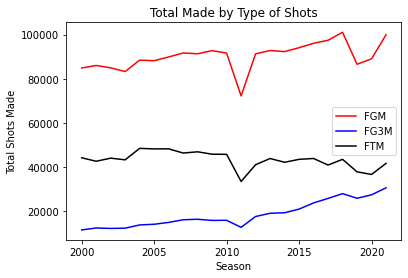

In [35]:
plt.plot(types_of_shots_sum.index, types_of_shots_sum['FGM'], label = "FGM", color = "red")
plt.plot(types_of_shots_sum.index, types_of_shots_sum['FG3M'], label = "FG3M", color = "blue")
plt.plot(types_of_shots_sum.index, types_of_shots_sum['FTM'], label = "FTM", color = "black")

plt.title("Total Made by Type of Shots")
plt.xlabel("Season")
plt.ylabel("Total Shots Made")

plt.legend()

plt.show()

For all three types of shots, we see a steady increase throughout the seasons though a dip in the 2011 or 2012 season where ```FGM``` seems to be affected the most. Why is that you may ask? As noted in the the descriptive statistics above, ```FGM```'s mean is roughly 2x and 5x higher than ```FTM``` and ```FG3M``` respectively. This is because, as noted in the ```data_dictionary``` above, ```FGM``` takes in both 2 and 3 pointers, which somewhat skews the data. To address this, create a new variable solely for 2-pointers.

In [36]:
df['FG2M'] = df['FGM'] - df['FG3M']

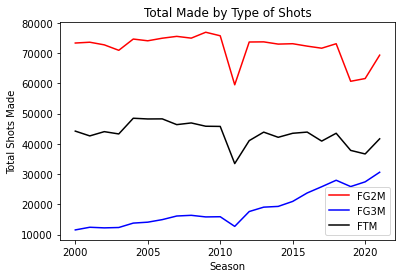

In [37]:
types_of_shots_sum = df.groupby('YEAR')[['FG2M', 'FG3M', 'FTM']].sum()

plt.plot(types_of_shots_sum.index, types_of_shots_sum['FG2M'], label = "FG2M", color = "red")
plt.plot(types_of_shots_sum.index, types_of_shots_sum['FG3M'], label = "FG3M", color = "blue")
plt.plot(types_of_shots_sum.index, types_of_shots_sum['FTM'], label = "FTM", color = "black")

plt.title("Total Made by Type of Shots")
plt.xlabel("Season")
plt.ylabel("Total Shots Made")

plt.legend()

plt.show()

### Confounding factors
If we just look at the number of 3 pointers made or attempted in a vacuum, we leave the door open for the confounding factor of mores overall scoring. We're not concerned about whether or not more scoring leads to more postseason success; rather, we're trying to determine if a higher *proportion* of 3-pointers relative to 2-pointers is a winning strategy.

In [38]:
# proportion of 3 points made to overall made
df['FG3_PROP'] =  df['FG3M']/df['FGM']
# proportion of 3 point attempts to overall made
df['FG3_PROPA'] = df.FG3A / df.FGA

### Quantifying playoff success

Now that we have our desired data for shot type, we can start taking a look at playoff success. The simplest way to define playoff success is binary: a team either makes the playoffs in a given season, or it doesn't. We can therefore create two new dataframes for playoff teams and non-playoff teams respectively.

In [39]:
#creates new dataframes to separate playoff teams and nonplayoff teams throughout the years
npo_df = df[(df['PO_WINS'] == 0) & (df['PO_LOSSES'] == 0)]
po_df = df[(df['PO_WINS'] != 0) | (df['PO_LOSSES'] != 0)]

In [40]:
npo_df.describe()
po_df.describe()

,TEAM_ID,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,PO_WINS,PO_LOSSES,...,FG3A,FG3_PCT,FTM,FTA,FT_PCT,PTS,PTS_RANK,FG2M,FG3_PROP,FG3_PROPA
count,3.520000e+02,352.00000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,...,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,1.610613e+09,2010.50000,80.386364,49.167614,31.218750,0.611705,4.497159,2.090909,5.173295,5.173295,...,1787.789773,0.360989,1474.178977,1933.363636,0.763807,8242.392045,12.502841,2411.769886,0.210186,0.267238
std,8.544924e+00,6.35332,4.203327,7.174883,6.938098,0.083388,2.294548,1.036500,4.705706,1.759329,...,607.233032,0.018360,178.913034,248.474866,0.031476,628.094840,7.980746,222.483831,0.067370,0.084187
min,1.610613e+09,2000.00000,66.000000,33.000000,9.000000,0.439000,1.000000,1.000000,0.000000,1.000000,...,641.000000,0.299000,889.000000,1198.000000,0.660000,6062.000000,1.000000,1605.000000,0.076320,0.103571
25%,1.610613e+09,2005.00000,82.000000,44.000000,26.000000,0.549000,2.750000,1.000000,1.000000,4.000000,...,1351.250000,0.349000,1363.250000,1745.750000,0.745000,7932.750000,5.000000,2277.500000,0.162267,0.204225
50%,1.610613e+09,2010.50000,82.000000,49.000000,32.000000,0.610000,4.000000,2.000000,3.000000,4.000000,...,1631.500000,0.360000,1474.000000,1915.000000,0.766000,8236.500000,12.000000,2459.500000,0.199206,0.249033
75%,1.610613e+09,2016.00000,82.000000,54.000000,37.000000,0.671000,6.250000,3.000000,7.000000,6.000000,...,2193.000000,0.374000,1586.250000,2095.000000,0.784000,8623.000000,19.000000,2561.500000,0.260495,0.329385
max,1.610613e+09,2021.00000,82.000000,73.000000,46.000000,0.890000,8.000000,6.000000,16.000000,11.000000,...,3721.000000,0.416000,1977.000000,2549.000000,0.839000,9686.000000,30.000000,2891.000000,0.411125,0.519475


### Distributions of variables
Now that we have our variables, we can check them for approximate normality. What follows is... skewed, but marginally so. We'll consider this "approximately normal" but proceed with caution.

<AxesSubplot:xlabel='FG3_PROP', ylabel='Count'>

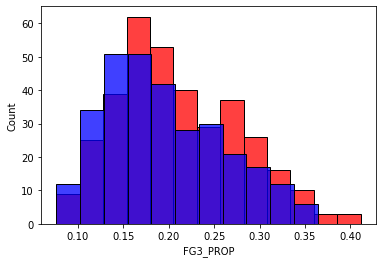

In [41]:
sns.histplot(po_df['FG3_PROP'], color='red')
sns.histplot(npo_df['FG3_PROP'], color='blue')

In [42]:
npo_df['FG3_PROP']

0      0.115786
1      0.145812
2      0.140609
3      0.148109
4      0.103331
         ...   
651    0.257742
652    0.296330
653    0.323711
654    0.342609
655    0.325827
Name: FG3_PROP, Length: 304, dtype: float64

The red bars represents the distrubition of the of all the team who made it to the playoffs and the blue bars represent the non-playoff teams. Here the x axis represents the proprotion of three pointers made by all of those teams and the y axis represents the count/frequency of those specified proportions occuring throughout the 20 seasons.

<AxesSubplot:xlabel='FG3_PROPA', ylabel='Count'>

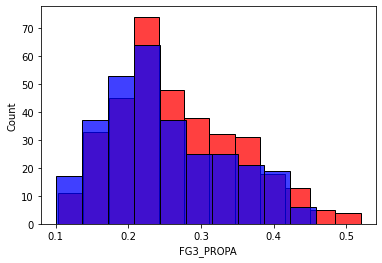

In [43]:
sns.histplot(po_df['FG3_PROPA'], color='red')
sns.histplot(npo_df['FG3_PROPA'], color='blue')

The red bars represents the distrubition of the of all the team who made it to the playoffs and the blue bars represent the non-playoff teams. Here the x axis represents the proprotion of three pointers attempted by all of those teams and the y axis represents the count/frequency of those specified proportions occuring throughout the 20 seasons.

<AxesSubplot:xlabel='FG3_PCT', ylabel='Count'>

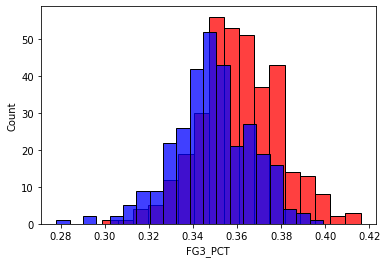

In [44]:
sns.histplot(po_df['FG3_PCT'], color='red')
sns.histplot(npo_df['FG3_PCT'], color='blue')

### Scatterplots
Let's see the distribution of our two groups over time.

<AxesSubplot:xlabel='YEAR', ylabel='FG3_PROP'>

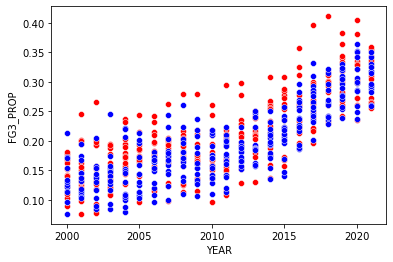

In [45]:
sns.scatterplot(x=po_df.YEAR, y=po_df.FG3_PROP, color='red')
sns.scatterplot(x=npo_df.YEAR, y=npo_df.FG3_PROP, color='blue')

<AxesSubplot:xlabel='YEAR', ylabel='FG3_PROPA'>

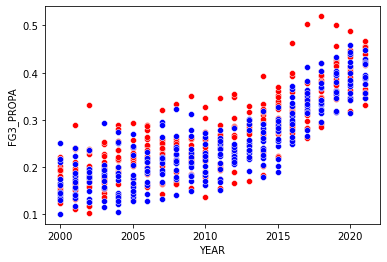

In [46]:
sns.scatterplot(x=po_df.YEAR, y=po_df.FG3_PROPA, color='red')
sns.scatterplot(x=npo_df.YEAR, y=npo_df.FG3_PROPA, color='blue')

<AxesSubplot:xlabel='YEAR', ylabel='FG3_PCT'>

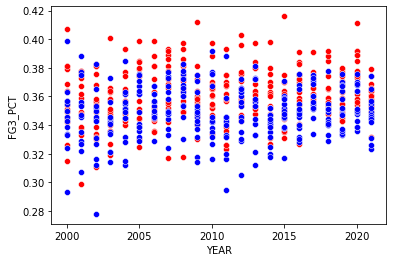

In [47]:
sns.scatterplot(x=po_df.YEAR, y=po_df.FG3_PCT, color='red')
sns.scatterplot(x=npo_df.YEAR, y=npo_df.FG3_PCT, color='blue')

Unsurprisingly, there has been steady increase in both groups over the years for both free throws attempted and made. Accuracy has stayed relatively the same. This agrees with the articles cited in our initial research. However, it appears that playoff teams tend to have higher percentages for our new variables regarding 3 pointers.

We've explored the relationship for 3 point proportions through the years between playoff teams and non-playoff teams. Let's see if there is difference in the 3 point proportions within the playoffs between teams with varying wins:

[Text(0.5, 1.0, '3 Point Percentage Averages for Teams of Various Playoff Wins')]

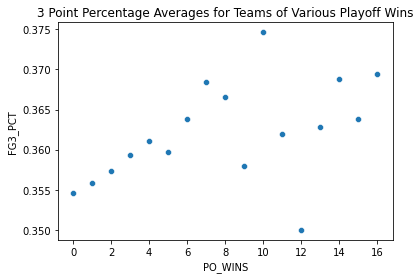

In [48]:
po_wins_fg3_pct = po_df.groupby('PO_WINS').mean()[['FG3_PCT']].reset_index()
sns.scatterplot(data=po_wins_fg3_pct, x='PO_WINS', y= 'FG3_PCT').set(title='3 Point Percentage Averages for Teams of Various Playoff Wins')

[Text(0.5, 1.0, '3 Point Percentage for All Teams of Various Playoff Wins')]

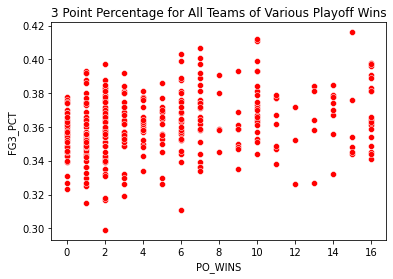

In [49]:
# Different way of scatterplotting po wins and 3 point percentage
sns.scatterplot(x=po_df.PO_WINS, y=po_df.FG3_PCT, color='red').set(title='3 Point Percentage for All Teams of Various Playoff Wins')

[Text(0.5, 1.0, ' Average Proportion of Shots that are 3 Pointers for All Teams of Various Playoff Wins')]

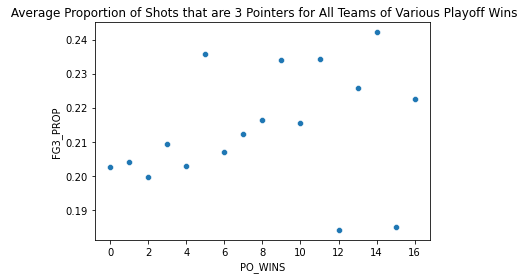

In [50]:
po_wins_fg3_prop = po_df.groupby('PO_WINS').mean()[['FG3_PROP']].reset_index()
sns.scatterplot(data=po_wins_fg3_prop, x='PO_WINS', y= 'FG3_PROP').set(title=" Average Proportion of Shots that are 3 Pointers for All Teams of Various Playoff Wins")

[Text(0.5, 1.0, 'Proportion of Shots made that are 3 Pointers for All Teams of Various Playoff Wins')]

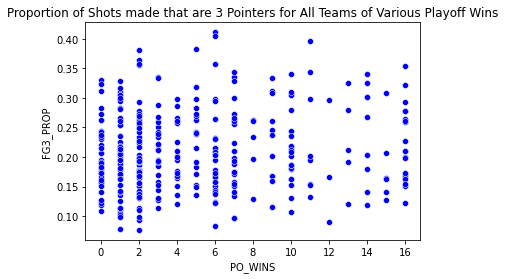

In [51]:
sns.scatterplot(x=po_df.PO_WINS, y=po_df.FG3_PROP, color='blue').set(title="Proportion of Shots made that are 3 Pointers for All Teams of Various Playoff Wins")

There seems to be a slight positive correlation between playoff wins and 3 point percentage and between playoff wins and proportion of shots that are 3 pointers.

With the meteoric rise of Stephen Curry and the Golden State Warriors, let's see if there is any correlation between the average 3 point percentage and playoff wins in the 3 point era (2000-2014) and pre 3 point era (2015-2021):

[Text(0.5, 1.0, '3 Point Percentage Averages for Teams of Various Playoff Wins')]

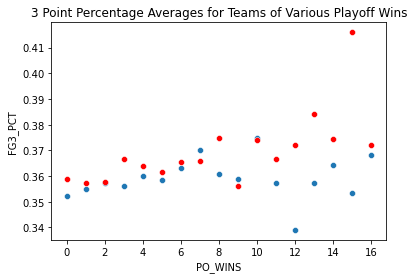

In [52]:
pre_2015 = po_df[po_df['YEAR'] < 2015]
po_wins_fg3_pct = pre_2015.groupby('PO_WINS').mean()[['FG3_PCT']].reset_index()
sns.scatterplot(data=po_wins_fg3_pct, x='PO_WINS', y= 'FG3_PCT')#.set(title='3 Point Percentage Averages for Teams of Various Playoff Wins 2000-2014')

post_2015 = po_df[po_df['YEAR'] >= 2015]
po_wins_fg3_pct = post_2015.groupby('PO_WINS').mean()[['FG3_PCT']].reset_index()
sns.scatterplot(data=po_wins_fg3_pct, x='PO_WINS', y= 'FG3_PCT', color='red').set(title='3 Point Percentage Averages for Teams of Various Playoff Wins')


Let's also explore if there is any correlation between the all 3 point percentage and playoff wins for all team's playoff performaces during the 3 point era (2000-2014) and during the pre 3 point era (2015-2021):

[Text(0.5, 1.0, '3 Point Percentage for All Teams of Various Playoff Wins 2015-2021')]

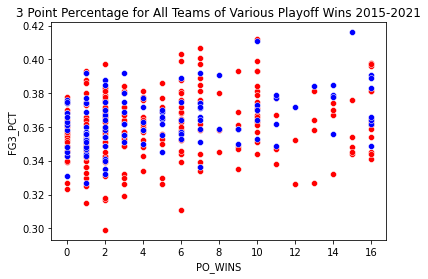

In [53]:
# Different way of scatter plotting po wins and 3 point percentage
sns.scatterplot(x=pre_2015.PO_WINS, y=pre_2015.FG3_PCT, color='red').set(title='3 Point Percentage for All Teams of Various Playoff Wins 2000-2015')
# Different way of scatter plotting po wins and 3 point percentage
sns.scatterplot(x=post_2015.PO_WINS, y=post_2015.FG3_PCT, color='blue').set(title='3 Point Percentage for All Teams of Various Playoff Wins 2015-2021')